In [24]:
import numpy as np
%matplotlib notebook
%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(18)
import tqdm
import matplotlib.animation as animation

Relu neurons

In [25]:
d = 2 # dimension of space
M = 4 # number of neurons for generation

In [26]:
def relu(x):
    if x >= 0:
        return x
    return 0.

In [27]:
def drelu(x):
    if x >= 0:
        return 1.
    return 0.

In [28]:
class Neuron:
    def __init__(self):
        a = np.random.normal()
        w = np.random.normal(size = d)
        b = np.random.normal()
        norm = np.linalg.norm(np.concatenate([np.array([b]), w]), 2)
        #norm = np.linalg.norm(np.concatenate([np.array([a, b]), w]), 2)
        #self.a = a / norm
        self.a = a
        self.w = w / norm
        self.b = b / norm
    def set_weights(self, a, w, b):
        self.a = a
        self.w = w.copy()
        self.b = b
    def forward(self, x):
        return self.a * relu(self.w.dot(x) + self.b)

In [29]:
class Network:
    def __init__(self, width):
        self.width = width
        self.neurons = [Neuron() for i in range(width)]
    def small_sphere(self, R):
        for nr in self.neurons:
            norm = 1./R * np.linalg.norm(np.concatenate([np.array([nr.b]), nr.w]), 2)
            nr.set_weights(nr.a, nr.w/norm, nr.b/norm)
        return
    def output(self, x):
        return np.mean([n.forward(x) for n in self.neurons])
    def loss(self, x, y):
        return .5*(self.output(x) - y)**2
    def grad(self, x, y):
        d = (self.output(x) - y)
        s = np.array([relu(n.w.dot(x) + n.b) for n in self.neurons])
        ds = np.array([drelu(n.w.dot(x) + n.b) for n in self.neurons])
        ga = 1./self.width * d * s
        gb = 1./self.width * d * np.array([self.neurons[i].a*ds[i] for i in range(self.width)])
        gw = np.array([gb[i] * x for i in range(self.width)]) # shape m * d
        return ga, gw, gb
    def step(self, x, y, tau):
        ga, gw, gb = self.grad(x, y)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def batch_step(self, X, Y, tau):
        ba = X.shape[0]
        Ga, Gw, Gb = np.zeros((ba, self.width)), np.zeros((ba, self.width, d)), np.zeros((ba, self.width))
        for i in range(ba):
            Ga[i], Gw[i], Gb[i] = self.grad(X[i], Y[i])
        ga, gw, gb = Ga.mean(axis = 0), Gw.mean(axis = 0), Gb.mean(axis = 0)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def sgd_train(self, X, Y, tau, epochs, batch, disp = True):
        for e in range(epochs):
            pm = np.random.permutation(X.shape[0])
            X = np.array([X[pm[i]] for i in range(X.shape[0])])
            Y = np.array([Y[pm[i]] for i in range(Y.shape[0])])
            if batch > 1:
                nbatch = X.shape[0]//batch
                subX = np.split(X, nbatch)
                subY = np.split(Y, nbatch)
                for s in range(len(subX)):
                    self.batch_step(subX[s], subY[s], tau)
            else:
                for i in range(X.shape[0]):
                    self.step(X[i], Y[i], tau)
            loss = self.test(X, Y)
            if disp:
                print('epoch '+str(e)+' : '+str(loss))
        return loss
    def test(self, X_t, Y_t):
        ts = X_t.shape[0]
        return np.mean([self.loss(X_t[i], Y_t[i]) for i in range(ts)])
    def gen_sample(self, s = 1):
        if s==1:
            X = np.random.normal(size = d)
            Y = self.output(X)
            return X, Y
        else:
            X = np.random.normal(size = (s, d))
            Y = np.zeros(s)
            for i in range(s):
                Y[i] = self.output(X[i])
            return X, Y
    def give_weights(self):
        la, lw, lb = np.zeros(self.width), np.zeros((self.width, d)), np.zeros(self.width)
        for i in range(self.width):
            nr = self.neurons[i]
            la[i] = nr.a
            lw[i] = nr.w
            lb[i] = nr.b
        return la, lw, lb
    def display_weights(self, fig, ax, scat = None, true_w = None, color='b'):
        assert d==2, 'must be in dimension 2'
        #ax.cla()
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        la, lw, _ = self.give_weights()
        x, y = np.zeros(self.width), np.zeros(self.width)
        for k in range(self.width):
            x[k] = lw[k, 0] * la[k]
            y[k] = lw[k, 1] * la[k] 
        if scat is None:
            pos = ax.scatter(x, y, s = 10., color=color)
        else:
            scat.set_offsets(np.array([x, y]).T)
            trace = ax.scatter(x, y, s = 5., color='grey', alpha = 0.4)
        if true_w is not None:
            tla, tlw, tlb = true_w
            tx, ty = np.zeros(tla.shape[0]), np.zeros(tla.shape[0])
            for k in range(tla.shape[0]):
                tx[k] = tlw[k, 0] * tla[k]
                ty[k] = tlw[k, 1] * tla[k]
                if tx[k]>= 0:
                    u = np.linspace(0., 2., 10)
                else:
                    u = np.linspace(-2., 0., 10)
                v = ty[k]/tx[k] * u
                ax.plot(u, v, color = 'k')
            ax.scatter(tx, ty, s = 100., color='r', alpha = 0.4)
                
        if scat is None:
            fig.canvas.draw()
        

<IPython.core.display.Javascript object>


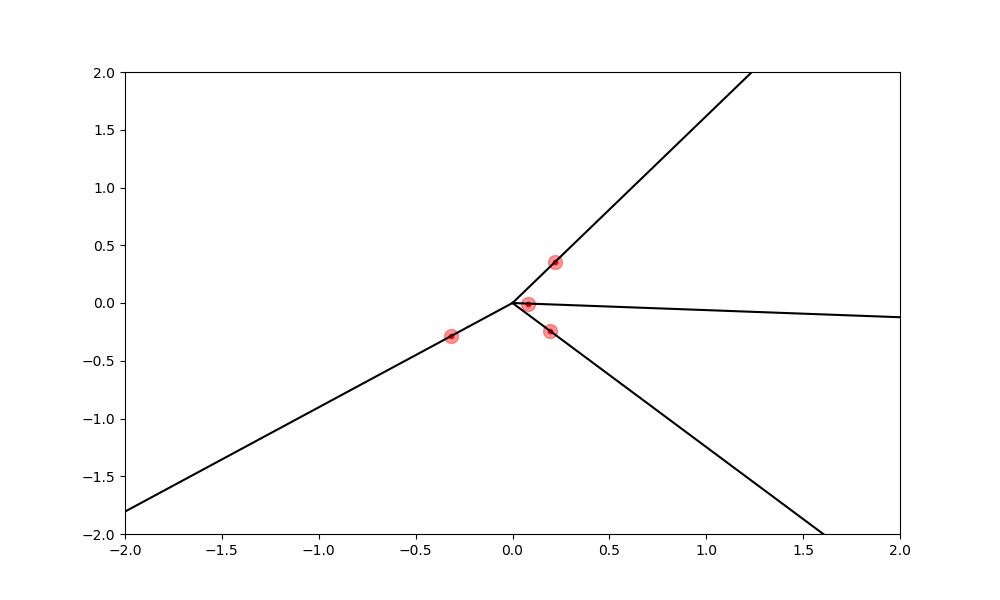

In [30]:
#np.random.seed(134)

fig, ax = plt.subplots(figsize=(10, 6))

gen_net = Network(M)
true_w = gen_net.give_weights()
gen_net.display_weights(fig, ax, color='r', true_w = true_w)

Initialize new network with parameters normal on small sphere.

Train it using SGD

Trying to reproduce the visual experiment

In [31]:
net = Network(20)
net.small_sphere(0.05) # the smaller the better ?

<IPython.core.display.Javascript object>


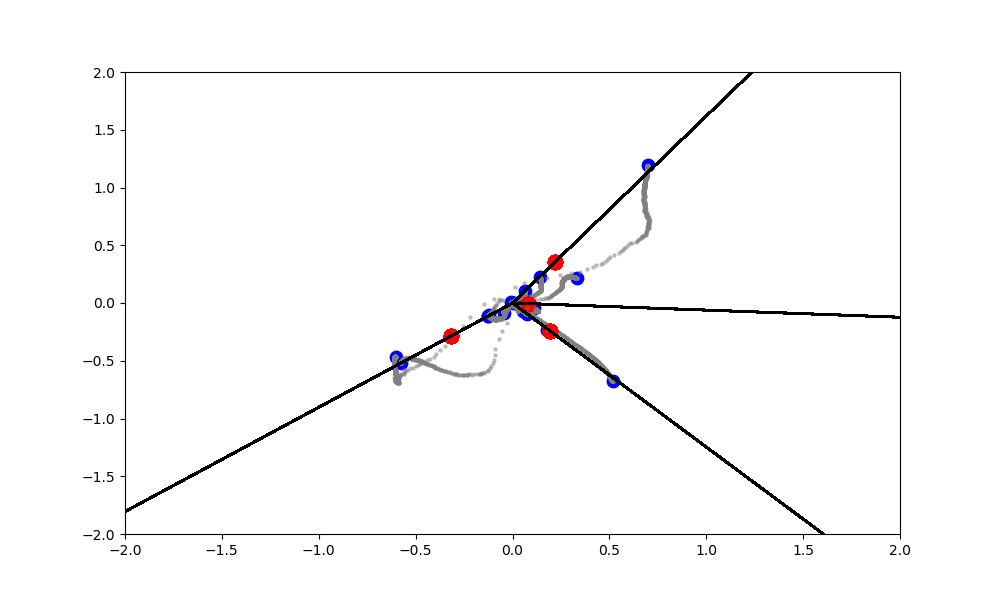

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

numframes = 500

scat = ax.scatter(None, None, s = 80., color='b')

def update_plot(i, scat, ax):
    #scat.set_array(data[i])
    print(i)
    X, Y = gen_net.gen_sample(100*int(np.log(10.+10.*i)))
    net.sgd_train(X, Y, tau = .5, batch = 20, epochs = 1, disp = False)
    
    net.display_weights(fig, ax, scat, true_w = true_w)
    return scat,

ani = animation.FuncAnimation(fig, update_plot, frames=numframes,
                                  fargs=(scat, ax), interval = 5, blit=True)

#ani.save('./relu.gif', writer='imagemagick', fps=60, bitrate = 0.03)
#plt.show()
#fig.canvas.draw()

In [35]:
#!brew install imagemagick 

106


In [34]:
#help(ani.save)

ReLU activation function: we show for each particle the trajectory $|w(t)| \theta(t) \in R^2$
 (here = a * w). The initialization is uniformly random on a (small) sphere around 0 (this satisfies asymptotically the separation condition). This case has a homogeneous structure and is treated separately in the paper.

What is the influence of:
    - the size of the initial weights sphere ?
    - the number of units ?
    - the original problem configuration ?